# Overview

Hurricane Ian was a Category 5 Atlantic hurricane, between Sep 21, 2022 and Oct 1, 2022.

In [ ]:
import os
import sys
import time
import warnings
from copy import deepcopy
from datetime import datetime, timedelta
from pathlib import Path 

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from cartopy.feature import NaturalEarthFeature
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LogNorm
from matplotlib.dates import DateFormatter
from pyproj import CRS
from shapely.geometry import Polygon, box, MultiPolygon
from shapely.ops import polygonize

from pyschism.mesh import Hgrid
from searvey.coops import coops_product_within_region, coops_stations_within_region
from stormevents import StormEvent

In [ ]:
warnings.filterwarnings("ignore")  # turn off warnings

In [ ]:
storm_name = 'ian'
storm_year = 2022

In [ ]:
run_dir = Path(os.getcwd())
path_to_Hgrid = run_dir / 'hgrid.gr3'
path_to_outputs = run_dir / 'outputs/out2d_1.nc'

In [ ]:
def create_obs_df(data_obs):
    df_obs, ij = [], 0
    for stationID in data_obs.coords['nos_id'].values:
        df1 = pd.DataFrame({'date': data_obs.coords['t'].values,
                     stationID: data_obs.v.values[ij,:],
                    }).set_index('date')
        df_obs.append(df1)
        ij = ij+1
    df_obs = pd.concat(df_obs, axis=1)
           
    return df_obs

In [ ]:
def find_indices2D(points, hgridFile):
    import numpy as np
    import scipy as sp
    longitude = hgridFile.x.T
    latitude = hgridFile.y.T
    long_lat = np.column_stack((longitude.ravel(),latitude.ravel()))
    tree = sp.spatial.cKDTree(long_lat)
    dist,idx = tree.query(points,k=1)
    ind = np.column_stack(np.unravel_index(idx,longitude.shape))
    return [i for i in ind]

In [ ]:
def get_schism_elevation_df(schism_output, station_indices_array, nos_ids):
    time_array = schism_output.time.values
    var_name = 'elevation'
    
    df_sim, ij = [], 0
    for idx in nos_ids:
        df_temp = pd.DataFrame({'date': time_array,
                                idx: schism_output[var_name][:,int(station_indices_array[ij])].values,
                               }).set_index('date')
        df_sim.append(df_temp)
        ij = ij+1 
    df_sim = pd.concat(df_sim, axis=1)
    return df_sim

In [ ]:
def plot_timeseries_comparison(data, data_observed=None, **kwargs):
    rounding_base = kwargs.get('rounding_base', None)
    station_label = kwargs.get('station_label', None)
    DPI = kwargs.get('DPI', None)
    save_file_name = kwargs.get('save_file_name', None)
    yd = kwargs.get('yd', None)
    yu = kwargs.get('yu', None)
    date_rng = kwargs.get('date_rng', None) # in datetime format (datetime(yyyy, mm, dd))

    base=1 if (rounding_base is None) else rounding_base
    
    # Figure dpi resolution:
    if DPI is None:       DPI = 120
    
    if station_label is None:
        station_label = ['NOS Station: '+str(x+1) for x in range(Nplots)]
    
    Nplots = data.shape[1]  # number of subplots (=number of selcted stations)
    if Nplots <=6:
        row, col = Nplots, 1 # number of rows and columns
        figW, figH = 6.5, min(8.0, row*2.0)  # Figure width and height
        figWspace, figHsapce = 0.00, 0.075
    else:
        row, col = int(np.ceil(Nplots/2)) , 2 # number of rows and columns
        figW, figH = 6.5, min(8.0, row*2.0)  # Figure width and height
        figWspace, figHsapce = 0.15, 0.10
        
    fig, axs = plt.subplots(row , col, figsize=(figW, figH), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = figHsapce, wspace=figWspace)
    
    axs = axs.ravel()
    for i in range(Nplots):
        axs[i].plot(data.iloc[:,i], linewidth=0.5, label='SCHISM')  # Simulation
        
        if data_observed is not None:
            axs[i].plot(data_observed.iloc[:,i], linewidth=0.5, label='COOPS')  # observed

        axs[i].grid(axis = 'both', color = 'gray', linestyle = '-', linewidth = 0.75, alpha=0.15)
        axs[i].tick_params(axis="both",direction="in")  #, pad=0
        plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=90)
        
        # format x-label
        plt.gcf().autofmt_xdate()
        # Define the date format
        date_form = DateFormatter("%b-%d")
        axs[i].xaxis.set_major_formatter(date_form)        
        axs[Nplots-2].tick_params(axis='x', rotation=90)
        axs[Nplots-1].tick_params(axis='x', rotation=90)        
        plt.setp(axs[Nplots-2].xaxis.get_majorticklabels(), ha='left')
        plt.setp(axs[Nplots-1].xaxis.get_majorticklabels(), ha='left')
         
        if date_rng is not None:
            plt.setp(axs[i], xticks=date_rng)
            axs[i].set_xlim([date_rng[0], date_rng[-1]])
        
        yd=base * np.floor(min(data.iloc[:,i])/base) if (yd is None) else yd
        yu=base *  np.ceil(max(data.iloc[:,i])/base) if (yu is None) else yu
#        axs[i].set_ylim([yd,yu])
        axs[i].set_ylim([-2.5,2.5])
    
    
        axs[i].text(0.5, 0.975, station_label[i],
                 horizontalalignment='center', verticalalignment='top',
                 transform=axs[i].transAxes, size=9,weight='bold')
    # add legend:
    axs[Nplots-1].legend(loc="lower right", ncol=3)
    
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    #plt.xlabel("Date")
    plt.ylabel('WSE (m)', size=11,weight='bold')

Get the best track data of Hurricane Ian, and write it into file (hurricane-track.dat)

In [ ]:
gdf_countries = gpd.GeoSeries(NaturalEarthFeature(category='physical', scale='10m', name='land').geometries(), crs=4326)

In [ ]:
storm = StormEvent(storm_name, storm_year)
storm_best_track = storm.track()
# storm_advisory_track = storm.track(advisories=['OFCL'])

In [69]:
water_levels_within_34kt = storm.coops_product_within_isotach('hourly_height', wind_speed=34)
water_levels_within_50kt = storm.coops_product_within_isotach('hourly_height', wind_speed=50)
water_levels_within_34kt

<xarray.Dataset>
Dimensions:  (t: 241, nos_id: 33)
Coordinates:
  * t        (t) datetime64[ns] 2022-09-21T06:00:00 ... 2022-10-01T06:00:00
  * nos_id   (nos_id) object '8720030' '8726384' ... '8665530' '8722956'
    nws_id   (nos_id) <U5 'FRDF1' 'PMAF1' 'FMRF1' ... 'DMSF1' 'CHTS1' 'PEGF1'
    x        (nos_id) float64 -81.47 -82.56 -81.87 ... -81.56 -79.92 -80.12
    y        (nos_id) float64 30.67 27.64 26.65 28.42 ... 30.39 32.78 26.08
Data variables:
    v        (nos_id, t) float32 1.568 1.814 2.081 2.281 ... 8.555 8.541 8.443
    s        (nos_id, t) float32 0.008 0.008 0.006 0.004 ... 0.005 0.005 0.004
    f        (nos_id, t) object '0,0' '0,0' '0,0' '0,0' ... '0,0' '0,0' '0,0'
    q        (nos_id, t) object <NA> <NA> <NA> <NA> <NA> ... <NA> <NA> <NA> <NA>

Plot the best track and 34/50/64kt wind swath around best track

In [ ]:
for idx in storm_best_track.linestrings['BEST']:
    track_date = idx

Text(0.5, 1.0, 'IAN 2022 CO-OPS maximum water levels [m]')

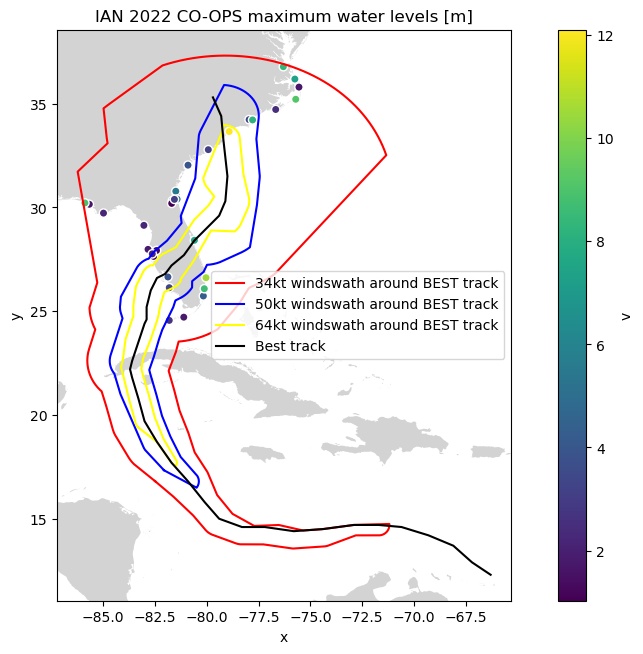

In [71]:
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(12, 12 / 1.61803398875)
   
axis.plot(*storm_best_track.wind_swaths(wind_speed=34)['BEST'][track_date].exterior.xy, c='red',
          label='34kt windswath around BEST track')

axis.plot(*storm_best_track.wind_swaths(wind_speed=50)['BEST'][track_date].exterior.xy, c='blue',
          label='50kt windswath around BEST track')

axis.plot(*storm_best_track.wind_swaths(wind_speed=64)['BEST'][track_date].exterior.xy, c='yellow',
          label='64kt windswath around BEST track')

axis.plot(*storm_best_track.linestrings['BEST'][track_date].xy, c='black',label='Best track')

water_levels_within_34kt.max('t').plot.scatter(x='x', y='y', hue='v', cmap='viridis', ax=axis)

xlim = axis.get_xlim()
ylim = axis.get_ylim()
gdf_countries.plot(color='lightgrey', ax=axis, zorder=-1)
axis.set_xlim(xlim)
axis.set_ylim(ylim)

axis.legend()
axis.set_title(f'{storm.name} {storm.year} CO-OPS maximum water levels [m]')

Text(0.5, 1.0, 'IAN 2022 CO-OPS maximum water levels [m]')

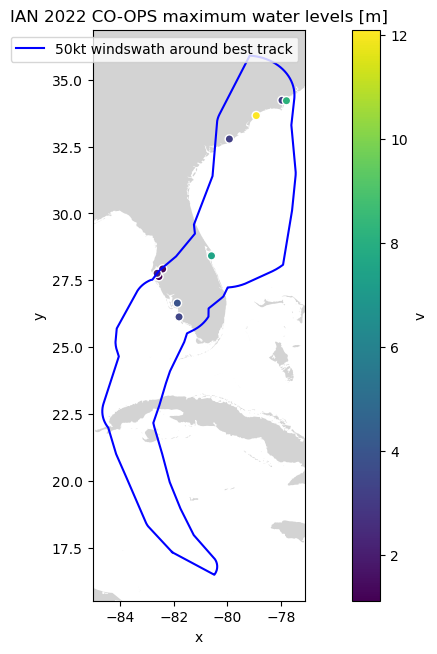

In [72]:
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(12, 12 / 1.61803398875)

axis.plot(*storm_best_track.wind_swaths(wind_speed=50)['BEST'][track_date].exterior.xy, c='blue',
          label='50kt windswath around best track')

water_levels_within_50kt.max('t').plot.scatter(x='x', y='y', hue='v', cmap='viridis', ax=axis)

xlim = axis.get_xlim()
ylim = axis.get_ylim()
gdf_countries.plot(color='lightgrey', ax=axis, zorder=-1)
axis.set_xlim(xlim)
axis.set_ylim(ylim)

axis.legend()
axis.set_title(f'{storm.name} {storm.year} CO-OPS maximum water levels [m]')

# Validation

Get CO-OPS data:

In [ ]:
storm_start_date = storm_best_track.start_date
storm_end_date = storm_best_track.end_date

In [ ]:
domain_50kt = MultiPolygon(list(polygonize(storm_best_track.wind_swaths(wind_speed=50)['BEST'][track_date].exterior)))
water_level = coops_product_within_region('water_level', 
                                          region=domain_50kt,
                                          start_date=datetime(storm_start_date.year, storm_start_date.month, storm_start_date.day), 
                                          end_date=datetime(storm_end_date.year, storm_end_date.month, storm_end_date.day))
# water_level.to_netcdf(coops_water_level.nc)

domain_st = coops_stations_within_region(region=domain_50kt)
coops_id = water_level['nos_id'].values

coops_id

In [ ]:
selected_stations = water_level['nos_id'].values
selected_stations

Text(0.5, 1.0, 'Maximum water levels observed by CO-OPS stations on the path of Hurriance IAN \n between 2022-09-22 18:00:00 and 2022-10-01 06:00:00')

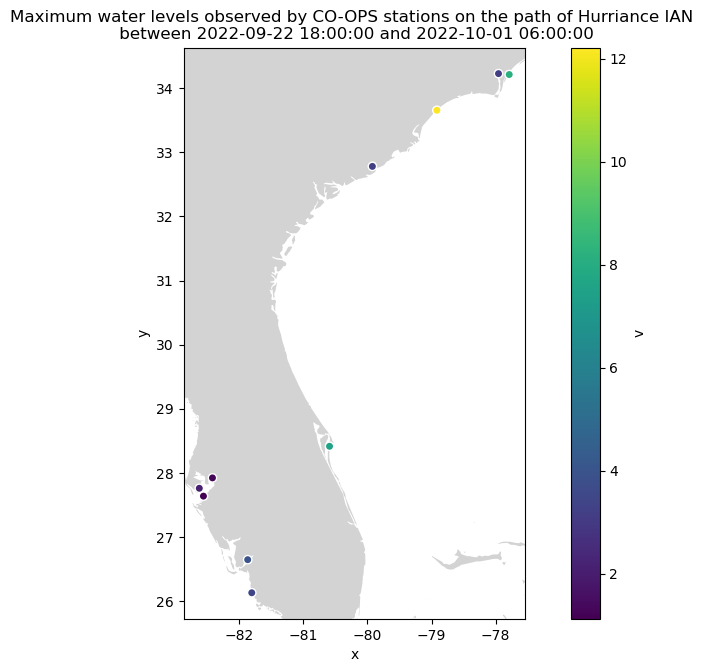

In [76]:
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(12, 12 / 1.61803398875)

water_level.max('t').plot.scatter(x='x', y='y', hue='v', cmap='viridis', ax=axis)

xlim = axis.get_xlim()
ylim = axis.get_ylim()
gdf_countries.plot(color='lightgrey', ax=axis, zorder=-1)
axis.set_xlim(xlim)
axis.set_ylim(ylim)

axis.set_title(f'Maximum water levels observed by CO-OPS stations on the path of Hurriance {storm.name} \n between {storm_start_date} and {storm_end_date}')

# Time series comparisons

In [ ]:
df_obs = create_obs_df(water_level)

Adjust observed sea level

In [ ]:
df_obs_adj = pd.DataFrame()
for idx in df_obs.columns:
    df_obs_adj[idx] = df_obs[idx] - df_obs[idx].values.mean()
df_obs_adj

Find simulated elevations for points corresponding to CO-OPS stations

In [ ]:
hgrid = Hgrid.open(path_to_Hgrid, crs='EPSG:4326')

In [ ]:
points_x = water_level.x.values
points_y = water_level.y.values

# adjust coordinates of nos_id=8725110 based on https://tidesandcurrents.noaa.gov/stationhome.html?id=8725110
points_x[4] = -81-48.5/60.0
points_y[4] = 26+7.9/60.0

points = np.column_stack([points_x, points_y])
points

In [ ]:
points_indices = find_indices2D(points, hgrid)
points_indices

In [ ]:
ds_sim = xr.open_dataset(path_to_outputs)

In [ ]:
df_sim = get_schism_elevation_df(ds_sim, points_indices, coops_id)
df_sim

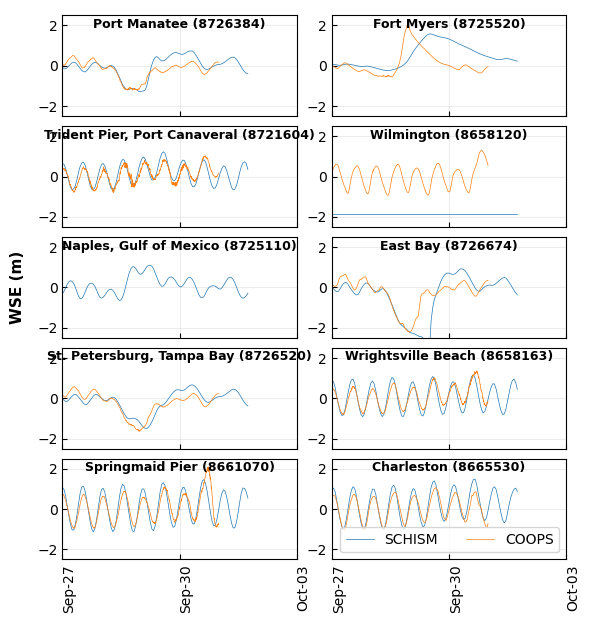

In [84]:
t0, te = datetime(2022, 9, 27), datetime(2022, 10, 2)

# t0, te = datetime(2018, 9, 10), datetime(2018, 9, 17)

dt = timedelta(days=3) 
date_rng = np.arange(t0, te+dt, dt)

station_label = domain_st.loc[coops_id.astype(int)].name.values

plot_timeseries_comparison(data=df_sim,
                           data_observed=df_obs_adj,
                           date_rng=date_rng,
                           station_label=[f'{n} ({i})' for n, i in zip(station_label, coops_id)]
                          )

# USGS HWMs

Text(0.5, 1.0, 'IAN 2022 height above ground [ft]')

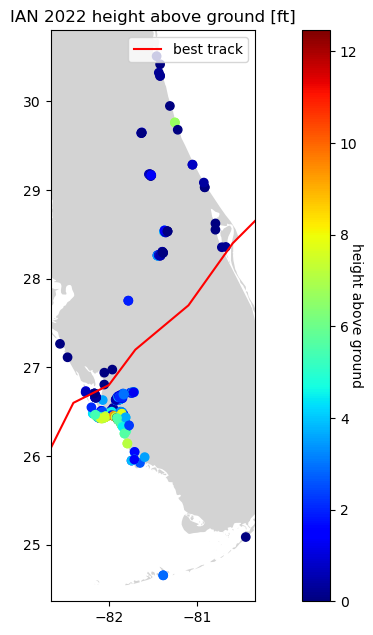

In [85]:
hwm = storm.flood_event.high_water_marks()
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(12, 12 / 1.61803398875)

hwm.plot('height_above_gnd', ax=axis, cmap='jet')
colorbar = plt.colorbar(
    ScalarMappable(
        norm=Normalize(
            vmin=hwm['height_above_gnd'].min(),
            vmax=hwm['height_above_gnd'].max(),
        ),
        cmap='jet'
    ),
)
colorbar.set_label('height above ground', rotation=270)

xlim = axis.get_xlim()
ylim = axis.get_ylim()
axis.plot(*storm_best_track.linestrings['BEST'][track_date].xy, c='red', label='best track')
gdf_countries.plot(color='lightgrey', ax=axis, zorder=-1)
axis.set_xlim(xlim)
axis.set_ylim(ylim)

axis.legend()
axis.set_title(f'{storm.name} {storm.year} height above ground [ft]')